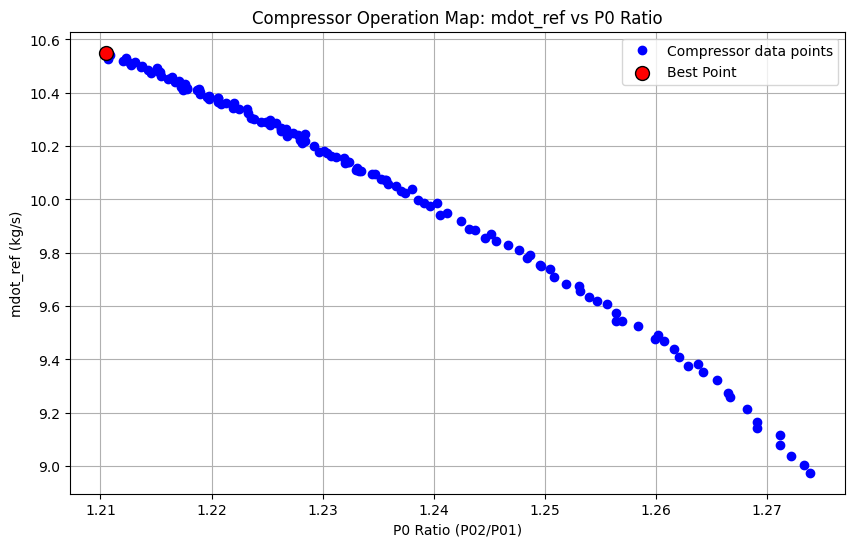

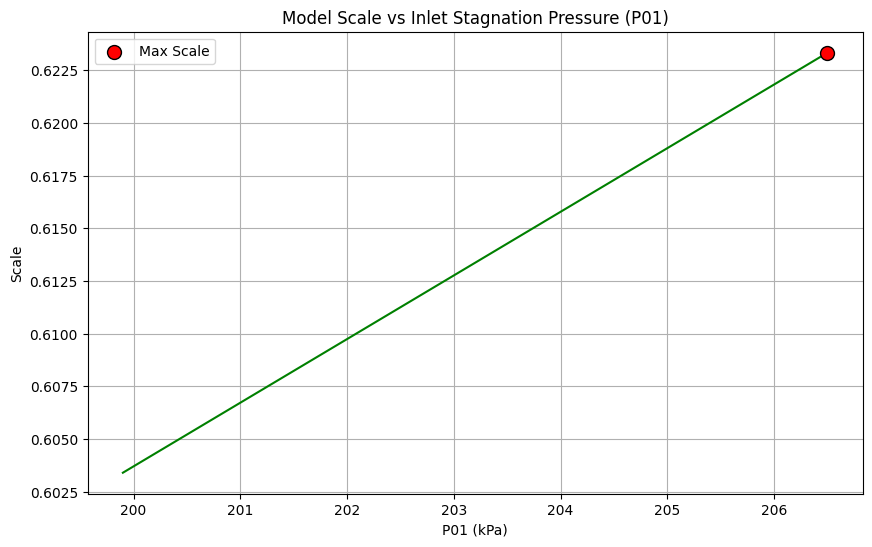

Maximum scale: 0.62333
Best inlet stagnation pressure P01: 206.500 kPa
Corresponding compressor map point and pressures:
mdr         10.550284
tor          1.068519
por          1.210454
l_model      0.124665
scale        0.623326
p01        206.500000
p02        249.958741
p03        246.209360
p04        241.934706
p05        229.837971
p4         196.974868
Name: 0, dtype: float64


In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Constants
T01 = 293.0            # Inlet stagnation temperature [K]
R = 287.0              # Specific gas constant for air [J/(kg·K)]
gamma = 1.4            # Heat-capacity ratio
Re = 3.0e6             # Reynolds number
mu = 1.83e-5           # Dynamic viscosity [Pa·s]
l_proto = 0.2          # Prototype characteristic length [m]
M = 0.55               # Mach number at station 4

# Load compressor map data
df = pd.read_excel('Compressor_operation_map.xlsx')
df.rename(columns={'mdot_ref(kg/s)': 'mdr', 'T0 ratio': 'tor', 'P0 ratio': 'por'}, inplace=True)

# Tracking variables
max_scale = 0.0
best_p01 = None
best_point = None
p01_values = []
scale_values = []

# Sweep P01 from 250 kPa down to 0 in 0.1 kPa steps
for p01 in np.arange(250.0, 0.0, -0.1):
    df['p01'] = p01
    df['p02'] = df['por'] * df['p01']  # stagnation at 2

    # Station 3 loss
    df['p03'] = 0.985 * df['p02']       # stagnation at 3

    # Static P3 check (must be ≤250 kPa)
    df['p3'] = df['p03'] / ((1 + ((0.5*(gamma-1))*(M**2)))**(gamma/(gamma-1)))
    feasible = df['p3'] <= 250.0
    if not feasible.any():
        continue
    df_f = df[feasible].copy()

    # Station 4 & 5 computations
    df_f['t02'] = df_f['tor'] * T01
    df_f['t03'] = df_f['t02']
    df_f['t04'] = df_f['t03']
    df_f['t4']  = df_f['t04'] / (1 + ((0.5*(gamma-1))*(M**2)))
    df_f['c4']  = M * np.sqrt(gamma * R * df_f['t4'])
    df_f['mdot'] = df_f['mdr'] * (df_f['p01'] / 101.325)
    df_f['l_model'] = df_f['mdot'] / (math.pi * Re * mu)
    df_f['scale'] = df_f['l_model'] / l_proto

    # density & static p4
    A4 = np.pi * df_f['l_model']**2
    df_f['rho4'] = df_f['mdot'] / (A4 * df_f['c4'])
    df_f['p4']   = df_f['rho4'] * R * df_f['t4'] / 1000      # static at 4 [kPa]
    df_f['p04']  = df_f['p4'] * ((df_f['t04'] / df_f['t4'])**(gamma/(gamma-1)))  # stagnation at 4
    df_f['p05']  = 0.95 * df_f['p04']                       # stagnation at 5

    # Final feasibility: all static and stagnation pressures ≤250, and p05 ≥ p01
    cond = (
        (df_f['p02'] <= 250.0) &
        (df_f['p03'] <= 250.0) &
        (df_f['p04'] <= 250.0) &
        (df_f['p05'] <= 250.0) &
        (df_f['p05'] >= df_f['p01'])
    )
    df_f = df_f[cond]
    if df_f.empty:
        continue

    # Store the max scale for this p01
    idx = df_f['scale'].idxmax()
    current_scale = df_f.loc[idx, 'scale']
    p01_values.append(p01)
    scale_values.append(current_scale)

    if current_scale > max_scale:
        max_scale = current_scale
        best_p01   = p01
        best_point = df_f.loc[idx]

# --- Plot 1: mdot_ref vs P0 ratio ---
plt.figure(figsize=(10, 6))
plt.plot(df['por'], df['mdr'], 'bo', label="Compressor data points")
plt.scatter(best_point['por'], best_point['mdr'], color='red', s=100, edgecolor='black', label="Best Point", zorder=5)
plt.title("Compressor Operation Map: mdot_ref vs P0 Ratio")
plt.xlabel("P0 Ratio (P02/P01)")
plt.ylabel("mdot_ref (kg/s)")
plt.legend()
plt.grid(True)
plt.savefig('Compressor_map_best_point.png')
plt.show()

# --- Plot 2: Scale vs P01 ---
plt.figure(figsize=(10, 6))
plt.plot(p01_values, scale_values, 'g-')
plt.scatter(best_p01, max_scale, color='red', s=100, edgecolor='black', label="Max Scale", zorder=5)
plt.title("Model Scale vs Inlet Stagnation Pressure (P01)")
plt.xlabel("P01 (kPa)")
plt.ylabel("Scale")
plt.grid(True)
plt.legend()
plt.savefig('Scale_vs_P01.png')
plt.show()

# Final result print
print(f"Maximum scale: {max_scale:.5f}")
print(f"Best inlet stagnation pressure P01: {best_p01:.3f} kPa")
print("Corresponding compressor map point and pressures:")
print(best_point[['mdr', 'tor', 'por', 'l_model', 'scale',
                  'p01', 'p02', 'p03', 'p04', 'p05', 'p4']])


## Scale values at different inlet stagnation pressures
# for i in range(len(p01_values)):
#     print(f"P_01 = {p01_values[i]} kPa, Scale = {scale_values[i]}")
